# Spam Detection
En este taller, realizaremos un pequeño proyecto completo donde se trabajarán conceptos vistos en cada una de las clases anteriores. Por un lado trabajaremos sobre texto realizando los preprocesados necesarios para finalizar construyendo un modelo de aprendizaje automático para detectar si un mensaje es *spam*.

Pistas: [stopwords, punctuation, CountVectorizer]

In [172]:
import string
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, f1_score, confusion_matrix, ConfusionMatrixDisplay

In [166]:
# el dataset se encuentra en la carpeta data
data = pd.read_csv(filepath_or_buffer="../data/spam.csv", encoding="latin-1", header=0, usecols=[0, 1], names=["label", "message"])

              precision    recall  f1-score   support

         ham       0.98      1.00      0.99       491
        spam       0.98      0.88      0.93        67

    accuracy                           0.98       558
   macro avg       0.98      0.94      0.96       558
weighted avg       0.98      0.98      0.98       558

f1 score (spam): 0.9291338582677166


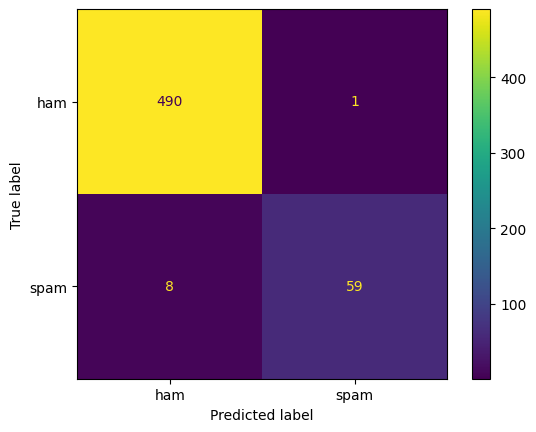

In [167]:
bow_messages = CountVectorizer(strip_accents="ascii", stop_words=stopwords.words("english")).fit_transform(data["message"])
X_train, X_test, y_train, y_test = train_test_split(bow_messages, data["label"], test_size=0.1, random_state=42)
predictions = SVC(kernel="linear", class_weight={"ham": 7.33, "spam": 1}).fit(X_train, y_train).predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=['ham','spam'])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['ham','spam'])
disp.plot()

print(classification_report(y_test, predictions))
print(f"f1 score (spam): {f1_score(y_test, predictions, pos_label='spam')}")


# Diagnosis

In [162]:
fail_ham_predicted = y_test[(predictions != y_test) & ('ham' == predictions)].index.tolist()

In [163]:
data.iloc[fail_ham_predicted]

,label,message
1044,spam,We know someone who you know that fancies you....
4071,spam,Loans for any purpose even if you have Bad Cre...
3979,spam,ringtoneking 84484
751,spam,You have an important customer service announc...
712,spam,08714712388 between 10am-7pm Cost 10p
1268,spam,Can U get 2 phone NOW? I wanna chat 2 set up m...
730,spam,Email AlertFrom: Jeri StewartSize: 2KBSubject:...
2662,spam,Hello darling how are you today? I would love ...


# Elaborado

In [170]:
import re
def Clean(Text):
    sms = re.sub('[^a-zA-Z]', ' ', Text) #Replacing all non-alphabetic characters with a space
    sms = sms.lower() #converting to lowecase
    sms = sms.split()
    sms = ' '.join(sms)
    return sms
data["clean_message"] = data["message"].apply(Clean)

In [173]:
data["tokenize_message"]=data.apply(lambda row: nltk.word_tokenize(row["clean_message"]), axis=1)

#

In [175]:
def remove_stopwords(text):
    stop_words = set(stopwords.words("english"))
    filtered_text = [word for word in text if word not in stop_words]
    return filtered_text


data["nostop_message"] = data["tokenize_message"].apply(remove_stopwords)

In [176]:
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
# lemmatize string
def lemmatize_word(text):
    #word_tokens = word_tokenize(text)
    # provide context i.e. part-of-speech
    lemmas = [lemmatizer.lemmatize(word, pos ='v') for word in text]
    return lemmas

data["lemmatize_message"] = data["nostop_message"].apply(lemmatize_word)

In [180]:
data['processed_message'] = data['lemmatize_message'].apply(lambda l: " ".join(l))

In [186]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

classifiers = [('rf', RandomForestClassifier()),
               ('knn',KNeighborsClassifier()), 
               ('svc',SVC())]
for _,cls in classifiers:
    cls.fit(X_train, y_train)

In [189]:
from sklearn.model_selection import cross_val_score

for model_name, model in classifiers:
    cv_score = cross_val_score(model, X_train,y_train,scoring="accuracy", cv=10)
    print(f'{model_name}/{cv_score.mean()}')

rf/0.976865392720535
knn/0.9228153255242504
svc/0.9796554301755055


              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       491
        spam       0.95      0.90      0.92        67

    accuracy                           0.98       558
   macro avg       0.97      0.94      0.96       558
weighted avg       0.98      0.98      0.98       558

f1 score (spam): 0.923076923076923


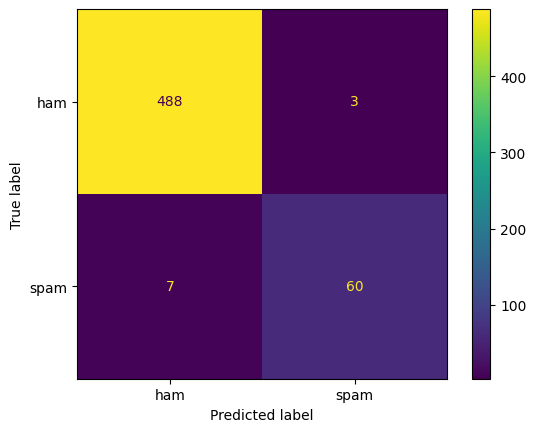

In [191]:
bow_messages = CountVectorizer().fit_transform(data["processed_message"])
X_train, X_test, y_train, y_test = train_test_split(bow_messages, data["label"], test_size=0.1, random_state=42)

predictions = SVC(kernel="linear", class_weight={"ham": 7.33, "spam": 1}).fit(X_train, y_train).predict(X_test)

cm = confusion_matrix(y_test, predictions, labels=["ham", "spam"])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ham", "spam"])
disp.plot()

print(classification_report(y_test, predictions))
print(f"f1 score (spam): {f1_score(y_test, predictions, pos_label='spam')}")